[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/VotingAlgorithms/blob/main/voting_explained.ipynb)

# Voting algorithms

### This notebook provides examples of the use of several classes that wrap voting algorithms in an abstraction layer, allowing for quick voting, both single and sequence voting, in order to examine the characteristics of individual election (voting) algorithms.

In [2]:
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from src.utils import annotate_heatmap, heatmap, similarity_matrix
from src.voting_complexity import test_voting_complexity
from src.voting_methods import DataAnalyser, VotingPreferences
from tqdm import tqdm

In [3]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.style.use("ggplot")
sns.set_style("whitegrid")

### Basic use case - single voting

Voting is represented by a set of voter preferences.
Each voter has their own list of preferences that determines how much they prefer a given candidate.

For example, voter **A** prefers candidate **0** (candidates are determined by their position on the list) because he assigned the most points (4 points) to him, then candidate number **1** (3 points) is his next choice and candidate **4** (0 points) is the least preferred.
Voter **B**, on the other hand, favors candidate **4** (4 points) the most, and candidate **0** (0 points) the least.

The example below was selected to show that for the same voting preferences, depending on the voting system we use, we can select different election winners.


In [3]:
# voter preferences
voter_a_pref = [4, 3, 2, 1, 0]
voter_b_pref = [0, 3, 2, 1, 4]
voter_c_pref = [4, 3, 1, 2, 0]
voter_d_pref = [0, 4, 2, 1, 3]

# we create a matrix containing the preferences of voters
vote_matrix = np.array([voter_a_pref, voter_b_pref, voter_c_pref, voter_d_pref])
# We will initialize VotingPreferences class using the above data
vot_pref = VotingPreferences(vote_matrix)

In [4]:
# Print plurality and borda results
print(f"Plurality voting results: {vot_pref.plurality_score}")
print(f"Borda voting results: {vot_pref.borda_score}")

Plurality voting results: [(0, 2), (1, 1), (4, 1), (2, 0), (3, 0)]
Borda voting results: [(1, 13), (0, 8), (2, 7), (4, 7), (3, 5)]


For the example used in the plurality (also called single-choice voting, simple plurality or relative/simple majority) voting (only the first voter preference counts, the remaining elements of the list and their order are not taken into account) candidate **0** wins, despite the fact that half of the voters consider it the worst option.

The Borda method takes into account the entire ranking of preferences, assigning points to candidates for all items, the higher on the list of preferences, the more points, there are many variants of assigning points, but the function linking points with the item must be non-increasing. In the simplest implementation used in this example, the point assignment looks like this: [n, n-1, n-2, ..., 0] where n is the number of candidates.

For this method, candidate **1** wins, he is the most preferred candidate by only one **D** voter, but all other voters consider him to be their number two choice.

Compared to the borda method, we could present majority voting as a ranking vote where only the first position is assigned a non-zero value, i.e. the allocation of points looks as follows: [1, 0, 0, ... , 0].

Ranking methods that take into account the remaining positions in the preference ranking, rather than just the first position, are considered to better reflect the views of voters and generate fairer results.

Instead of assigning a preference score to the VotingPreferences class, you can also provide voter rankings, which determine the order in which candidates are preferred. The following example is a set of rankings equivalent to the above voting score.

In [5]:
voter_a_rank = [0, 1, 2, 3, 4]
voter_b_rank = [4, 1, 2, 3, 0]
voter_c_rank = [0, 1, 3, 2, 4]
voter_d_rank = [1, 4, 2, 3, 0]

ranks = np.array([voter_a_rank, voter_b_rank, voter_c_rank, voter_d_rank])
vot_pref_rank = VotingPreferences(ranks, ground_truth=None, use_ranks=True)

For example, voter **B** favors candidate **4** the most, so he is first on the ranking. Next, it best prefers candidate **1**, so there is the second.

This is reflected in point notation where these candidates received 4 and 3 points respectively from voter **B**

In [6]:
# The results are the same
print(f"Plurality voting results: {vot_pref_rank.plurality_score}")
print(f"Borda voting results: {vot_pref_rank.borda_score}")

Plurality voting results: [(0, 2), (1, 1), (4, 1), (2, 0), (3, 0)]
Borda voting results: [(1, 13), (0, 8), (2, 7), (4, 7), (3, 5)]


The transformation of point preferences into ranking is done as follows and the VotingPreferences class performs this transformation when *use_ranks=False*

In [7]:
reverse_order = np.argsort(vote_matrix)
ranks = np.fliplr(reverse_order)

### Voting performance

The computational complexity of selecting a candidate depends on the number of voters, the number of candidates and the voting algorithm used. Let's see how the computational complexity changes for selected algorithms depending on the number of candidates.

In [8]:
methods = [
    "plurality",
    "copeland",
    "borda",
    "symetric_borda",
    "simpson",
    "dowdall",
    "baldwin",
    "nanson",
    "bucklin",
    "stv",
]

candidates_list = [i for i in range(2, 25, 2)]
voters_n = 50
trials = 1000

In [9]:
results = test_voting_complexity(
    candidates_list=candidates_list, voters_n=voters_n, trials_n=trials, methods=methods
)

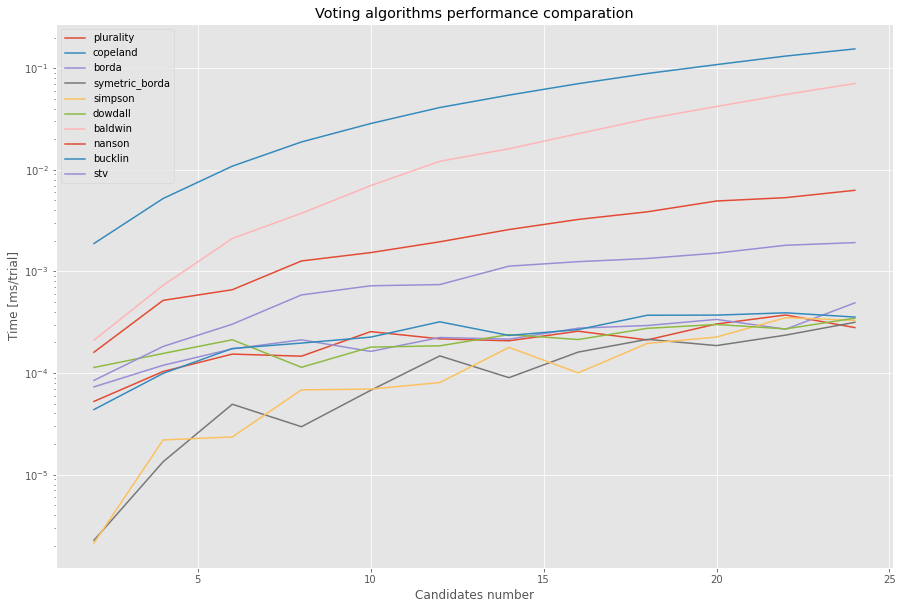

In [27]:
for method in methods:
    plt.semilogy(
        results[method]["candidates"], [i / trials for i in results[method]["time"]]
    )

plt.title("Voting algorithms performance comparation")
plt.ylabel("Time [ms/trial]")
plt.xlabel("Candidates number")

plt.legend(methods)
plt.show()

### Distribution of voting

An interesting experiment is to check what distributions generate individual votes. Let us assume that the voters and candidates lie on a 2D space and their position is given by the flat distribution, from (0,0) to (1,1).

Voters rank candidates according to the distance they are between them (Euclidean distance). Let us see what the distribution of election winners will be, depending on the election method, for voters and candidates coming from a flat distribution.

In [2]:
class SeabornFig2Grid:
    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(
            self.sg, sns.axisgrid.PairGrid
        ):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """Move PairGrid or Facetgrid"""
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """Move Jointgrid"""
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot
        )

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [3]:
def find_committee(similarity_matrix, candidate_number):
    vot_pref = VotingPreferences(similarity_matrix, ground_truth=None)

    result_dict = {
        "plurality": [i[0] for i in vot_pref.plurality_score[:candidate_number]],
        "copeland": [i[0] for i in vot_pref.copeland_score[:candidate_number]],
        "borda": [i[0] for i in vot_pref.borda_score[:candidate_number]],
        "symetric_borda": [
            i[0] for i in vot_pref.symetric_borda_score[:candidate_number]
        ],
        "simpson": [i[0] for i in vot_pref.simpson_score[:candidate_number]],
        "dowdall": [i[0] for i in vot_pref.dowdall_score[:candidate_number]],
    }

    return result_dict

In [4]:
def get_random_candidates(voters_number):
    voters = np.random.uniform(0, 1, (voters_number, 2))
    distance_matrix = np.zeros((voters_number, voters_number))
    for i in range(voters_number):
        for j in range(i, voters_number):
            if i == j:
                distance_matrix[i, j] = 0
                distance_matrix[j, i] = 0
            else:
                norm = np.linalg.norm(voters[i] - voters[j])
                distance_matrix[i, j] = 2 - norm
                distance_matrix[j, i] = 2 - norm
    return distance_matrix, voters

In [17]:
voters_number = 30
candidate_number = 5
tests = 5000
methods = ["plurality", "copeland", "borda", "symetric_borda", "simpson", "dowdall"]

In [18]:
start = time.time()
committee_distribution = {}
for method in methods:
    committee_distribution[method] = []
for i in tqdm(range(tests)):
    sm, v = get_random_candidates(voters_number)
    co = find_committee(sm, candidate_number)
    for method in methods:
        positions = co[method]
        points = v[positions, :]
        committee_distribution[method].extend(points.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:20<00:00, 10.00it/s]


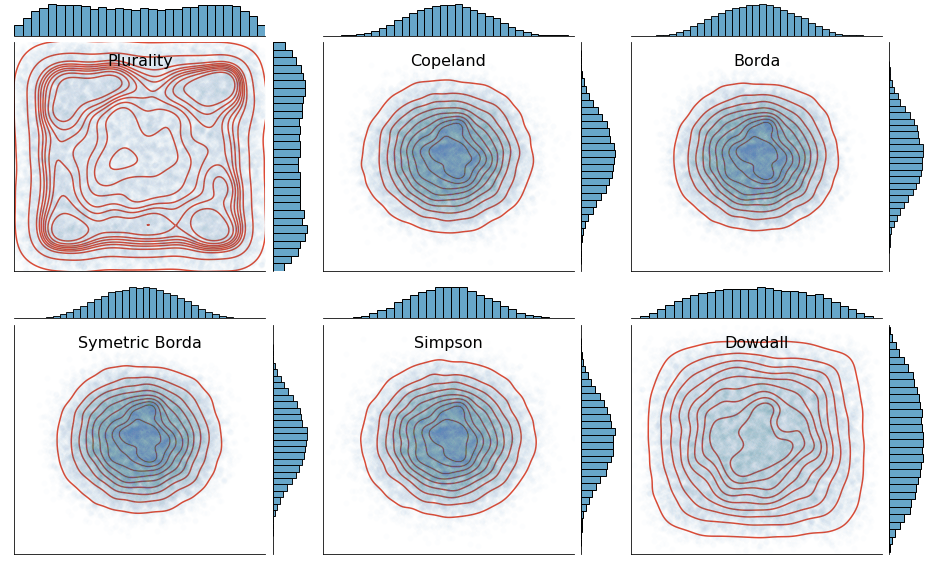

In [27]:
jointplots = []
nice_methods = [
    "Plurality",
    "Copeland",
    "Borda",
    "Symetric Borda",
    "Simpson",
    "Dowdall",
]
for i, method in enumerate(methods):
    x = np.array(committee_distribution[method]).T[0]
    y = np.array(committee_distribution[method]).T[1]
    #     jp = sns.jointplot(x=x, y=y, kind="kde",
    #                                     xlim=(0, 1), ylim=(0,1))
    #     jp = sns.jointplot(x=x, y=y, xlim=(0, 1), ylim=(0,1))

    jp = sns.jointplot(
        x=x,
        y=y,
        xlim=(0, 1),
        ylim=(0, 1),
        alpha=0.01,
        color=[52 / 256, 138 / 256, 185 / 256],
        marginal_kws=dict(bins=30),
    )
    jp.plot_joint(
        sns.kdeplot, zorder=0, levels=10, color=[226 / 256, 74 / 256, 51 / 256]
    )

    jp.ax_joint.set_yticks([])
    jp.ax_joint.set_xticks([])
    jp.ax_joint.text(
        0.5, 0.9, nice_methods[i], fontsize=16, horizontalalignment="center"
    )
    jointplots.append(jp)

fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(2, 3)

mg0 = SeabornFig2Grid(jointplots[0], fig, gs[0])
mg1 = SeabornFig2Grid(jointplots[1], fig, gs[1])
mg2 = SeabornFig2Grid(jointplots[2], fig, gs[2])
mg3 = SeabornFig2Grid(jointplots[3], fig, gs[3])
mg4 = SeabornFig2Grid(jointplots[4], fig, gs[4])
mg5 = SeabornFig2Grid(jointplots[5], fig, gs[5])

gs.tight_layout(fig)
# plt.title('Distribution of the location of the voting wieners in 2D space', fontsize=24)
# plt.show()
plt.savefig("winners_distribution.jpg")

Voters set their preferences and choose candidates. Euclidean distance was used as a preference measure. The closer the candidate is to the voter, the higher his position on the list of preferences. Then, the voting algorithms presented above were used to select the voting winners. Although the distribution of voters (and candidates) comes from a uniform distribution,
the generated distribution of voting winners is characterized by disturbances specific to a given voting
method. Some voting methods reward centrist candidates because they may be relatively high on the preference lists of voters from a large part of the sampling space